In [2]:
import numpy as np
import time
import ray
ray.init(lru_evict=True)

2020-04-04 14:56:42,717	INFO resource_spec.py:212 -- Starting Ray with 2.54 GiB memory available for workers and up to 1.27 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-04 14:56:43,245	INFO services.py:1148 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.0.0.118',
 'redis_address': '10.0.0.118:65035',
 'object_store_address': '/tmp/ray/session_2020-04-04_14-56-42_703003_2232/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-04_14-56-42_703003_2232/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-04_14-56-42_703003_2232'}

In [3]:
@ray.remote
def hill_enc(plaintext):
    
    M = np.array([[25,15,20],[7,8,22],[7,13,13]])
    if len(plaintext)%3!=0: plaintext = plaintext + "x"*(((len(plaintext)//3) + 1)*3 - len(plaintext))
    plaintext_ascii = [ord(i)-97 for i in plaintext[0:(len(plaintext)*((len(plaintext)//3)+1))]]
    plaintext_three_words_ascii = [np.asarray(plaintext_ascii[i:i+3]) for i in range(0,len(plaintext_ascii),3)]
    ciphertext_three_words_ascii = [np.matmul(M, i) for i in plaintext_three_words_ascii]
    ciphertext_three_words_ascii = [chr((j%26)+97) for i in ciphertext_three_words_ascii for j in i]
    c = "".join(ciphertext_three_words_ascii)
    
    return c

In [4]:
hill_single_core_list = []

def hill_single_core(length_list):
    for i in length_list:
        plaintext = "a"*i
        
        start_time = time.time()
        
        full_at_a_time = hill_enc.remote(plaintext)
        full_at_a_time = ray.get(full_at_a_time)
        
        hill_single_core_list.append(time.time() - start_time)

In [10]:
hill_double_core_list = []

def hill_double_core(length_list):
    for i in length_list:
        plaintext = 'a'*i
        first_half = plaintext[:len(plaintext)//2]
        second_half = plaintext[len(plaintext)//2:]
        
        start_time = time.time()
        
        first_half = hill_enc.remote(first_half)
        second_half = hill_enc.remote(second_half)
        
        first_half = ray.get(first_half)
        second_half = ray.get(second_half)
        
        hill_double_core_list.append(time.time() - start_time)

In [6]:
length_list = [96, 996, 9996, 99996, 999996, 9999996]
hill_single_core(length_list)

TypeError: 'list' object cannot be interpreted as an integer

In [7]:
print(hill_single_core_list)

[0.016333818435668945, 0.008794069290161133, 0.0444028377532959, 0.4989898204803467, 21.374417781829834, 2046.4640791416168]


In [11]:
hill_double_core(length_list)
print(hill_double_core_list)

[0.014108896255493164, 0.0074388980865478516, 0.02737116813659668, 0.19913697242736816, 8.458359003067017, 95.52696299552917]


In [12]:
import numpy as np
import pandas as pd

data = []
finaldata = []
for i, j, k in zip(length_list, hill_single_core_list, hill_double_core_list):
    data.append([i, j, k])

data = np.array(data)
pd.DataFrame(data, columns=['Plaintext length','Single core', 'Double core'])

,Plaintext length,Single core,Double core
0,96.0,0.016334,0.014109
1,996.0,0.008794,0.007439
2,9996.0,0.044403,0.027371
3,99996.0,0.498990,0.199137
4,999996.0,21.374418,8.458359
5,9999996.0,2046.464079,95.526963


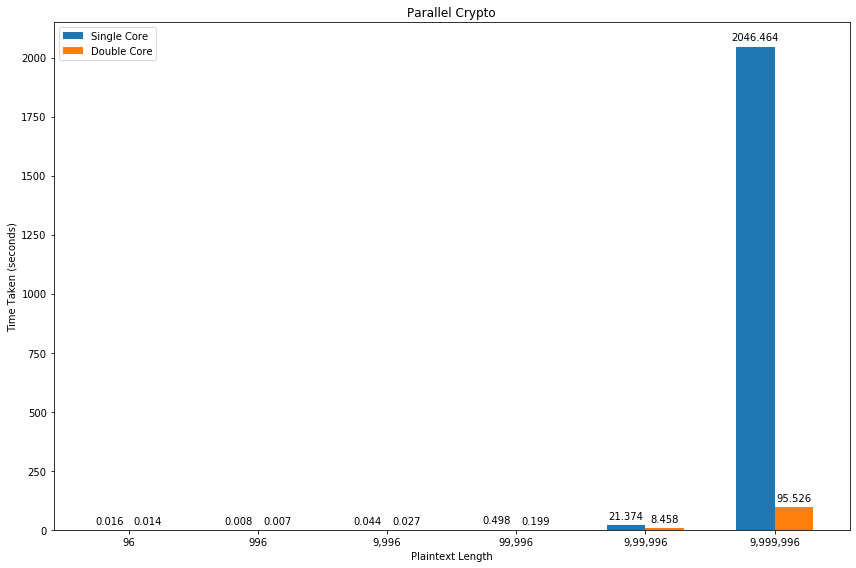

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import decimal

labels = ['96', '996', '9,996', '99,996', '9,99,996', '9,999,996']

decimal.getcontext().rounding = decimal.ROUND_DOWN
hill_single_core_list_1 = [decimal.Decimal(i) for i in hill_single_core_list]
hill_double_core_list_1 = [decimal.Decimal(i) for i in hill_double_core_list]

hill_single_core_list_1 = [float(round(i,3)) for i in hill_single_core_list_1]
hill_double_core_list_1 = [float(round(i,3)) for i in hill_double_core_list_1]

x = np.arange(len(labels))
width = 0.30

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, hill_single_core_list_1, width, label='Single Core')
rects2 = ax.bar(x + width/2, hill_double_core_list_1, width, label='Double Core')

ax.set_ylabel('Time Taken (seconds)')
ax.set_xlabel('Plaintext Length')
ax.set_title('Parallel Crypto')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4), 
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

plt.show()